# Smoothing

This notebook shows how to use `dysh` to smooth a spectrum.   

For the example below we will use data from the Position-Switch example again.
The following dysh commands are the simplest to get and smooth a spectrum (leaving out all the function arguments):

      sdf = GBTFITSLoad()
      sb = sdf.getps()
      ta = sb.timeaverage()
      tb = ta.smooth()
      tb.plot()

or if you wish to make use of the Python object chaining you can do this in one line:

       GBTFITSLoad().getps().timeaverage().smooth().plot()

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for working with the data.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(test="getps")

18:46:37.832 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction

### Calibration and Time Averaging

This test data has 8 scans making up 4 pairs of OnOff observations. We will calibrate all of the OnOff scan pairs, time average them and then compare the results with and without smoothing. To calibrate all of the scans, we can omit the `scan=` keyword when using the `sdfits.getps` method.

*Technical note*: ``getps`` returns a **ScanBlock** with in this case four `PSScan`s, since there are four pairs of OnOff observations.


The noise in the time averaged spectrum is 36 mK. However, this has not been baseline subtracted and there is a slope in the continuum.
In addition, the edges look horrible, and there is a strong "spike" (galactic) emission near channel 3000.   We like to avoid using those data for the baseline fit.

Stats : mean: 0.2708 K median: 0.2711 K rms: 0.0359 K min: 0.14 K max: 0.42 K
Expect: mean: 0.2708 K median: 0.2711 K rms: 0.0359 K min: 0.14 K max: 0.42 K
Stats : mean: 0.2916 K median: 0.2916 K rms: 0.0366 K min: 0.14 K max: 0.41 K
Expect: mean: 0.2916 K median: 0.2916 K rms: 0.0366 K min: 0.14 K max: 0.41 K


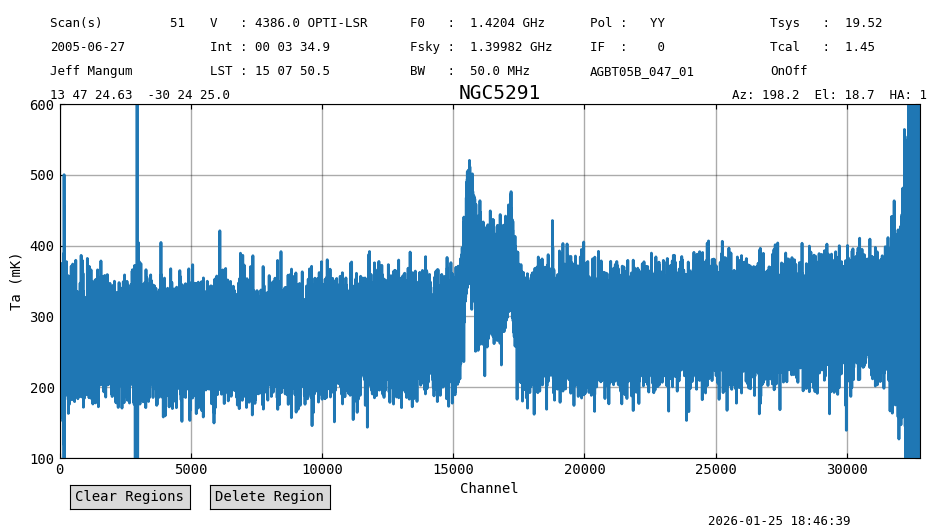

In [6]:
scan_block = sdfits.getps(ifnum=0, plnum=0, fdnum=0)
ta = scan_block.timeaverage()
ta.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=100, ymax=600, grid=True)

# Define a string for printing the spectrum statistics.
fmt_str = "mean: {mean:.4f} median: {median:.4f} rms: {rms:.4f} min: {min:.2f} max: {max:.2f}"
print(f"Stats : {fmt_str}".format(**ta[5000:14000].stats()))
print("Expect: mean: 0.2708 K median: 0.2711 K rms: 0.0359 K min: 0.14 K max: 0.42 K")
print(f"Stats : {fmt_str}".format(**ta[20000:30000].stats()))
print("Expect: mean: 0.2916 K median: 0.2916 K rms: 0.0366 K min: 0.14 K max: 0.41 K")

### Baseline Removal

We remove the slope by baseline fitting an order 1 polynomial from the data while ignoring the channels that contain a signal. This is done using the `Spectrum.baseline()` method.

18:46:39.719 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1374818364.0 Hz, 1379040470.9335938 Hz) 
, Spectral Region, 1 sub-regions:
  (1397351017.8085938 Hz, 1403454533.4335938 Hz) 
, Spectral Region, 1 sub-regions:
  (1419476261.9492188 Hz, 1424816838.1210938 Hz) 
]


Stats : mean: -0.0007 K median: -0.0007 K rms: 0.0358 K min: -0.13 K max: 0.15 K
Expect: mean: -0.0007 K median: -0.0007 K rms: 0.0358 K min: -0.13 K max: 0.15 K


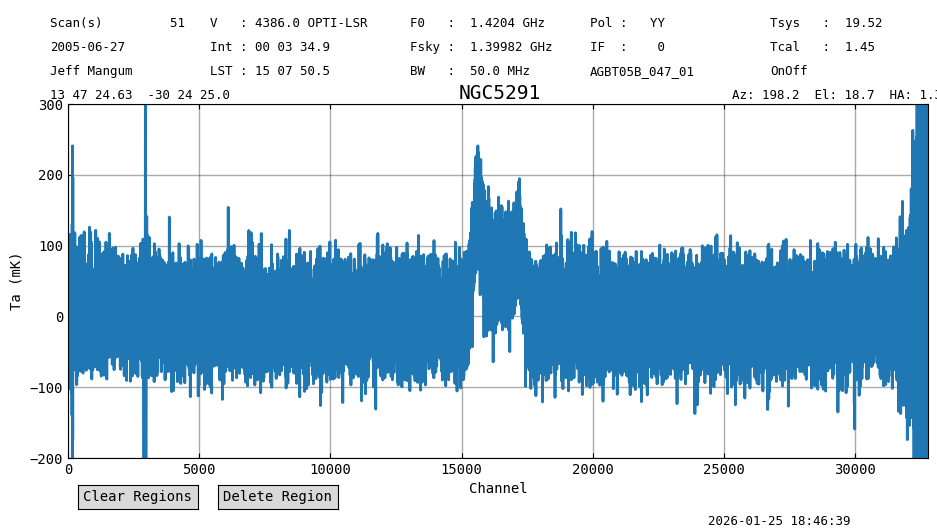

In [7]:
ta.baseline(model="poly", degree=1, include=[[3500,14000],[18000,30000]], remove=True)
ta.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ta[5000:14000].stats()))
print("Expect: mean: -0.0007 K median: -0.0007 K rms: 0.0358 K min: -0.13 K max: 0.15 K")

### Smooth in a Few Ways

By default smoothing will also decimate the signal, to (roughly) make each channel independant of the next. This assuming the input signal had independant channels. If your input was oversampled by a factor of 2, the smoothed signal will be as well, although you can manually decimate by a different value too, for example by using ``decimate=8`` .

Since we smooth to a gauss of FWHM 16 channels, the noise should go down by a factor of 4 (36 mK to 9 mK).

Stats : mean: -0.0007 K median: -0.0007 K rms: 0.0075 K min: -0.02 K max: 0.02 K
Expect: mean: 0.0005 K median: 0.0004 K rms: 0.0075 K min: -0.02 K max: 0.03 K


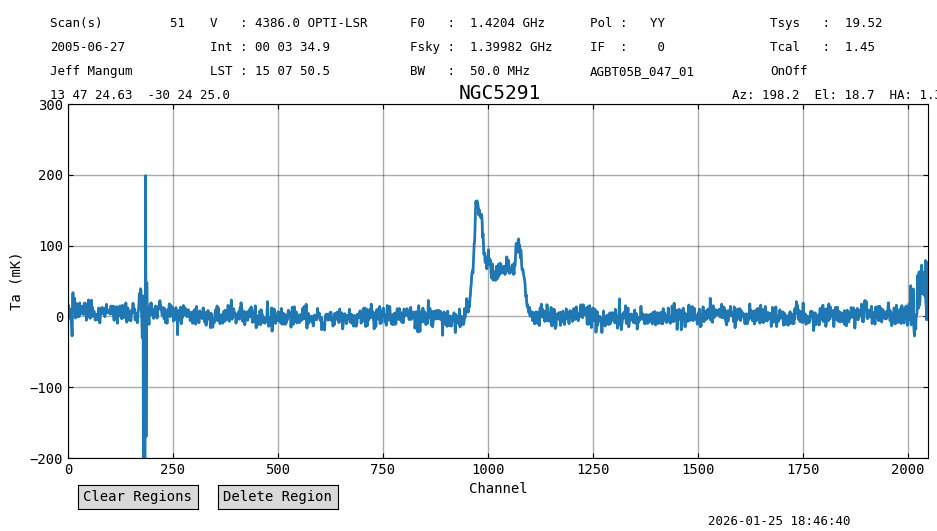

In [8]:
ts1 = ta.smooth('gaussian', 16)
ts1.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ts1[5000//16:14000//16].stats()))
print("Expect: mean: 0.0005 K median: 0.0004 K rms: 0.0075 K min: -0.02 K max: 0.03 K")

The noise is now 8 mK, very close to the improvement we expected.

Now smoothing by 320 channels should result in a noise of $55/\sqrt{320}$ or 2 mK. In this case we will use a box as the convolving kernel.

We will also estimate the correlation between channels by comparing the noise in the spectra with the noise in the spectra when we subtract adjacent channels (using `roll=1` in `Spectrum.stats()`).

Stats : mean: -0.0007 K median: -0.0010 K rms: 0.0023 K min: -0.01 K max: 0.00 K
Rolled rms/rms ratio: 0.784559642491622


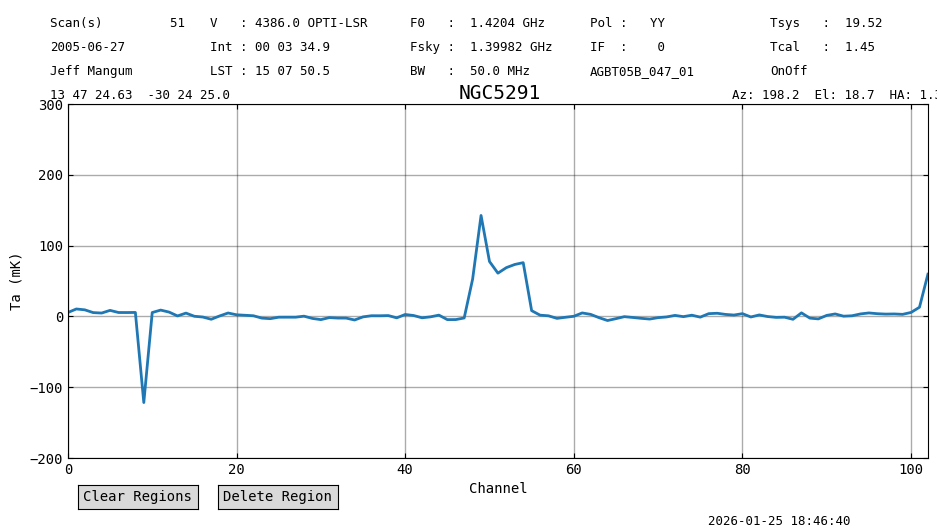

In [9]:
ts2 = ta.smooth('box', 320)
ts2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)

print(f"Stats : {fmt_str}".format(**ts2[5000//320:14000//320].stats()))
rratio = ts2[5000//320:14000//320].stats(roll=1)["rms"]/ts2[5000//320:14000//320].stats(roll=0)["rms"]
print(f"Rolled rms/rms ratio: {rratio}")

The noise in the smoothed spectrum is ~2 mK, as expected.

The rolled RMS ratio is very close to 1, so neighboring channels are not related. If you would decimate by 160, you would see this ratio drop. Be sure to adjust the range of channels for any new computations of the spectrum statistics (`Spectrum.stats`).

### Smoothing the Reference ("OFF") Scans

Under certain circumstances it can be beneficial to (boxcar) smooth the reference (OFF) signal before the usual
(ON-OFF)/OFF calibration. 

*Technical note*:  if you want to achieve identical results to GBTIDL, the width of the boxcar needs to be odd.


Stats : mean: 0.2667 K median: 0.2666 K rms: 0.0254 K min: 0.18 K max: 0.35 K
Expect: mean: 0.2667 K median: 0.2666 K rms: 0.02536 K min: 0.18 K max: 0.35 K


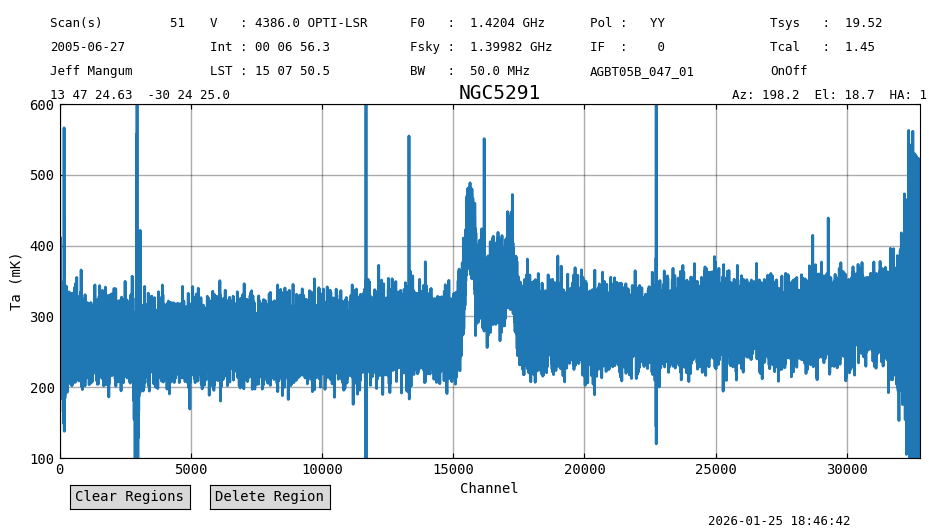

In [10]:
scan_block2 = sdfits.getps(ifnum=0, plnum=0, fdnum=0, smoothref=31)
ta2 = scan_block2.timeaverage()
ta2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=100, ymax=600, grid=True)
print(f"Stats : {fmt_str}".format(**ta2[5000:10000].stats()))   # avoid spikes
print("Expect: mean: 0.2667 K median: 0.2666 K rms: 0.02536 K min: 0.18 K max: 0.35 K")

When smoothing the reference spectra, the noise in the time average of the calibrated spectrum is 25 mK. For a given 
value of the `smoothref=`$N$ the improvement is 

$$
\sqrt{\frac{N+1}{2N}}
$$

Given that the RMS was 36 mK we would expect $\sqrt(32/62) \approx 0.72$ times, or 26 mK. At best this will give about 30% improvement.
See our [sdmath](https://dysh.readthedocs.io/en/latest/reference/sdmath.html) for more details.


We repeat the baseline subtraction using the same model.

18:46:42.539 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1397351017.8085938 Hz, 1403454533.4335938 Hz) 
]


Stats : mean: 0.0009 K median: 0.0007 K rms: 0.0270 K min: -0.19 K max: 0.50 K
Expect: mean: 0.0009 K median: 0.0007 K rms: 0.0270 K min: -0.19 K max: 0.50 K


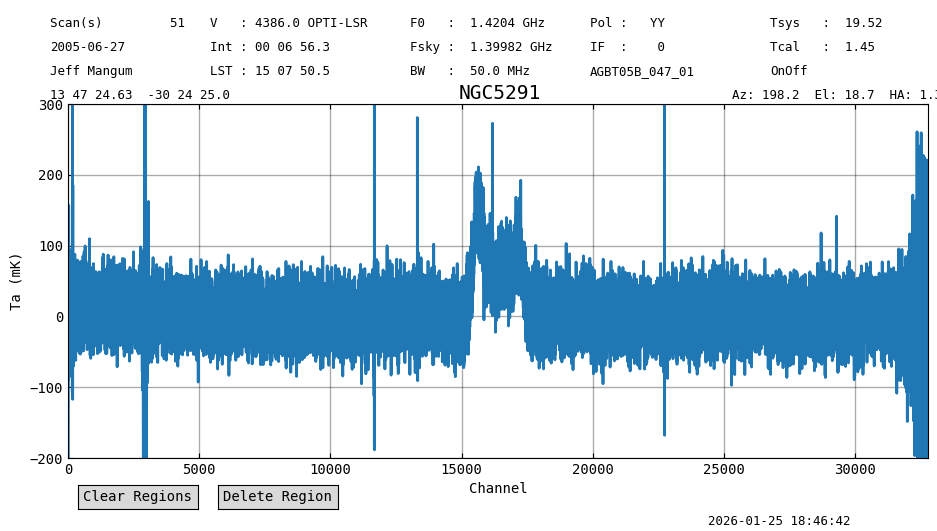

In [11]:
ta2.baseline(model="poly", degree=1, exclude=[(14000,18000)], remove=True)
ta2.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ta2[5000:14000].stats()))
print("Expect: mean: 0.0009 K median: 0.0007 K rms: 0.0270 K min: -0.19 K max: 0.50 K")

We could smooth this spectrum the normal way, as was done a few cells ago, and not much difference is visible, except for the noise.

Stats : mean: 0.0009 K median: 0.0007 K rms: 0.0023 K min: -0.00 K max: 0.01 K
Rolled rms/rms ratio: 0.7802636696042748


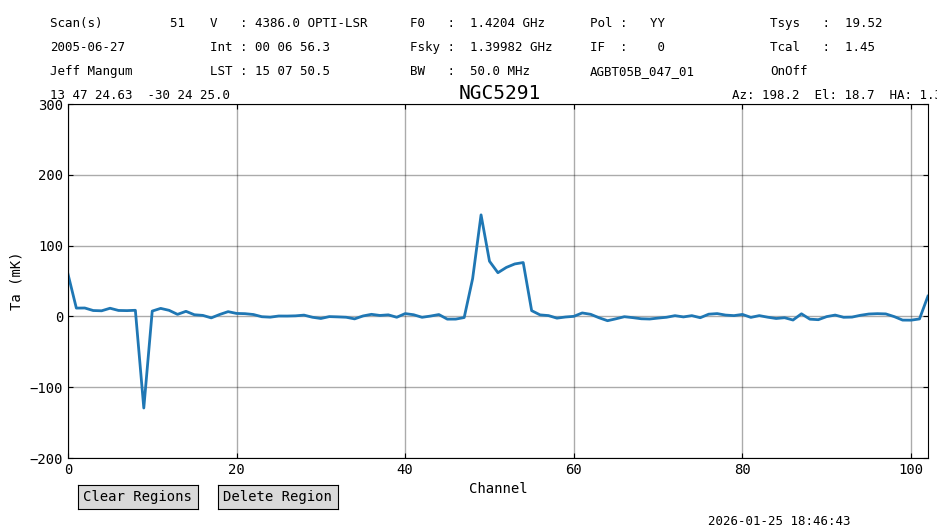

In [12]:
ts3 = ta2.smooth('box', 320)
ts3.plot(xaxis_unit="chan", yaxis_unit="mK", ymin=-200, ymax=300, grid=True)
print(f"Stats : {fmt_str}".format(**ts3[5000//320:14000//320].stats()))
rratio = ts3[5000//320:14000//320].stats(roll=1)["rms"]/ts3[5000//320:14000//320].stats(roll=0)["rms"]
print(f"Rolled rms/rms ratio: {rratio}")

The RMS has gone down (2.4 mK to 2.3 mK), but the signal correlation has also increased from 1.06 to 1.10. This increase is due to the added correlation of the reference smoothing.

## Successive Smoothing

Smoothing with a Gaussian twice in a row should be the same as smoothing with a single Gaussian of the square root of the sum of their squares. Note that the **width** is the final width (FWHM) of the smoothing operation. We need to ignore decimation here, which is the third argument (`decimate=-1`), otherwise the spectra will have a different number of channels.

We plot the difference between the two smoothing routes, which is perhaps surprisingly still below 1e-8. It is not closer to 0 due to the finite range the Gaussian is sampled (to 4 sigma).

Stats : mean: -2.945e-10 K median: 4.285e-09 K rms: 7.291e-07 K min: -2.8e-06 K max: 2.7e-06 K


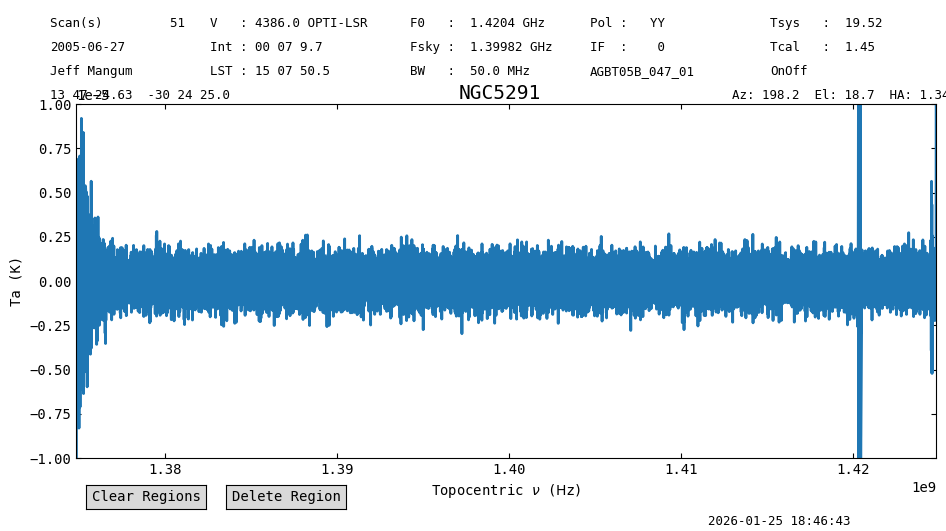

In [13]:
ts5a = ta.smooth('gaussian', width=3, decimate=-1).smooth('gaussian', width=5, decimate=-1)
ts5b = ta.smooth('gaussian', width=5, decimate=-1)
diff = ts5a-ts5b
diff.plot(ymin=-0.00001, ymax=0.00001)

fmt_str = "mean: {mean:.4g} median: {median:.4g} rms: {rms:.4g} min: {min:.2g} max: {max:.2g}"
print(f"Stats : {fmt_str}".format(**diff[5000:14000].stats()))

## Final Stats
Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.


In [14]:
ts5b.stats()   # rms 0.04618235 K

{'mean': <Quantity 0.00557439 K>,
 'median': <Quantity 0.00235092 K>,
 'rms': <Quantity 0.04618235 K>,
 'min': <Quantity -1.6402636 K>,
 'max': <Quantity 0.67591415 K>,
 'npt': 32768,
 'nan': 0}